Overview 
=======

Chronic illness readmission is one of the leading cost drivers for healthcare providers in the United States, for several reasons:

* Complexity of care required to treat ongoing conditions
* Resource costs for specialists required to treat chronic conditions
* Patient transport and facility transition costs during readmission
* Reimbursement penalties associated with patient readmission within 30 days.

In health systems across the country, clinical service providers are now attempting to stratify patients into "Readmission Risk" groups, based on their current conidtion, medical history, and demographic information. 

Once patients are identified, they are tagged and then assigned to a specific team of clinicians (mainly doctors and nurses) that have specialized skills to properly treat and discharge.

## Scope ##

In this study, we analyze a set of patient data from the UCLA School of Medicine in an attempt to predict whether or not a patient will be readmitted within 30 days, after 30 days, or not at all. Anonymized data was pulled from the UCLA Medical School Learning Library, and represents clinical data for over 100,000 patients with diatbetes from 2001-2011.

Because this data only pertains to patients with diabetes, the results of **this analysis can only be generalized to diabetic admissions**.

## Evaluation Metrics ##

Current practices assume that patients will not be readmitted at all, until proven otherwise. So we will test the accuracy of our model against 2 metrics:

* A model that predicts "No Readmission" every time
* A null model that predicts the most common readmission case every time

Exploratory Data Analysis
=====

First, we import the data and observe the dateframe's shape, columns, and sizes

In [2]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

plt.style.use('fivethirtyeight')

In [3]:
#import data and label keys

diabetes_path = '../data/dataset_diabetes/diabetic_data.csv'
dbd = pd.read_csv(diabetes_path)

key_path = '../data/dataset_diabetes/IDs_mapping.csv'
key = pd.read_csv(key_path)

We check the shape, feature types, and look at the dataframe at a high level

In [4]:
dbd.dtypes
dbd.head(5)
dbd.shape

(101766, 50)

It looks like some columns have a lot of missing values, so we inspect further using .describe() and value_counts, starting with "weight".

In [87]:
dbd.describe(include = 'all')
dbd.loc[:,'weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

A heavy majority of the "weight" column values are missing, so we're going to drop this feature from the dataframe.

In [88]:
dbd.drop('weight', axis =1, inplace=True)

It looks like the payer_code and medical_specialty have over half of their values missing, so we will drop those features as well. 

Additionally, we will drop the encounter_id and patient_nbr, since they are arbitrary ID numbers assigned to each patient admission, and drop the A1Cresult amnd max_glu_serum, because these tests were only run on 3% of patients.

In [89]:
dbd.drop('payer_code', axis =1, inplace=True)
dbd.drop('medical_specialty', axis =1, inplace=True)
dbd.drop('encounter_id', axis =1, inplace = True)
dbd.drop('patient_nbr', axis =1, inplace = True)
dbd.drop('A1Cresult', axis =1, inplace = True)
dbd.drop('max_glu_serum', axis =1, inplace = True)

Finally, we have 3 "diagnosis" features, each with a unique ID that maps to an initial, second, and third diagnosis. Unfortunately, we were unable to acquire a data dictionary for the "Diagnosis IDs", so we will be forced to drop those as well, since we can't interpret them.

In [90]:
dbd.drop('diag_1', axis =1, inplace = True)
dbd.drop('diag_2', axis =1, inplace = True)
dbd.drop('diag_3', axis =1, inplace = True)

In [91]:
dbd.head(5)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Because the "age" feature is represented in ranges, we're going to need to convert this feature into something that the Classifier can use. In this case, we're going to have to create dummy variables for each age range, since we don't know the exact age of each patient

In [92]:
age_dummies = pd.get_dummies(dbd, columns=["age"])
dbd = age_dummies

#Drop first Age Dummy Column to remove redudancy
dbd.drop("age_[0-10)", axis = 1, inplace=True)

Next, we map race, gender, and diabetes_med. Gender will be mapped 0 for "male" and 1 for "female", and diabetes_med will be mapped 0 for "no meds administered" and 1 for "diabetes meds administered"

In [93]:
dbd.loc[:, 'diabetesMed'] = dbd.loc[:, 'diabetesMed'].map({'No': 0, 'Yes': 1}) 
dbd.loc[:, 'change'] = dbd.loc[:, 'change'].map({'No': 0, 'Ch': 1})
dbd.loc[:, 'gender'] = dbd.loc[:, 'gender'].map({'Male': 0, 'Female': 1})

In [94]:
dbd.loc[:, 'race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

Race will have be mapped to values from range(1-5) for each race, and we will map "?" to the "Other" category

In [95]:
#create race-mapping dictionary

race_mapping = {
    'Caucasian': 0,
    '?': 3,
    'AfricanAmerican': 1,
    'Hispanic': 2,
    'Other': 3,
    'Asian': 4,
}

dbd.loc[:, 'race'] = dbd.loc[:, 'race'].map(race_mapping)

It looks like admission_type_id, discharge_disposition_id, and admission_source_id, have "?" values that need to be handled, so we will address them by mapping "?" to NaN for each of these features, and then dropping the rows with NaN values

In [96]:
# Create dictionary for admin ID

admin_id = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: None,
    6: None,
    7: 5,
    8: None
} 

#Map using admin_ID
dbd.loc[:,'admission_type_id'] = dbd.loc[:,'admission_type_id'].map(admin_id)

In [97]:
#Create dictionary for discharge_disposition_ID
dd_id = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10,
    11: 11,
    12: 12,
    13: 13,
    14: 14,
    15: 15,
    16: 16,
    17: 17,
    18: None,
    19: 19,
    20: 20,
    21: 21,
    22: 22,
    23: 23,
    24: 24,
    25: None,
    26: None,
    30: 30,
    27: 27,
    28: 28,
    29: 29
}

#Map dicharge_disposition_id using dd_id dictionary
dbd.loc[:,'discharge_disposition_id'] = dbd.loc[:,'discharge_disposition_id'].map(dd_id)

In [98]:
#Create admission_id dictionary

as_id = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: None,
    10: 10,
    11: 11,
    12: 12,
    13: 13,
    14: 14,
    15: None,
    17: None,
    18: 18,
    19: 19,
    20: None,
    21: None,
    22: 22,
    23: 23,
    24: 24,
    25: 25,
    26: 26
}

#map admission_id using dictionary
dbd.loc[:,'admission_source_id'] = dbd.loc[:,'admission_source_id'].map(as_id)

Within the dataset, there are also drug columns, which indicate whether or not the patient is on a steady regiment (Steady), lowered dose (Down), higher dose (Up), or not given the drug (No).

We will need to map those as well.

In [99]:
#create list of all drugs in dataset
drugs = ["metformin", 
         "repaglinide", 
         "nateglinide", 
         "chlorpropamide", 
         "glimepiride", 
         "acetohexamide", 
         "glipizide", 
         "glyburide", 
         "tolbutamide", 
         "pioglitazone", 
         "rosiglitazone", 
         "acarbose", 
         "miglitol", 
         "troglitazone", 
         "tolazamide", 
         "examide", 
         "citoglipton", 
         "insulin", 
         "glyburide-metformin", 
         "glipizide-metformin", 
         "glimepiride-pioglitazone", 
         "metformin-rosiglitazone", 
         "metformin-pioglitazone"]

#Before mapping, loop through each drug and check value counts
for drug in drugs:
    print(dbd.loc[:, drug].value_counts())

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64
No        101765
Steady         1
Name: acetohexamide, dtype: int64
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64
No        101743
Steady        23
Name: tolbutamide, dtype: int64
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dty

Upon inspection, we find  several drugs with very low administration rates (< 100 times), so we can drop those.

In [100]:
#drop drugs with low administration rates
dbd.drop(['glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'], axis = 1, inplace = True)

With the remaining medications, we need to map the status to ordinal numeric values. In this case, we will use 0 for No, 1 for Down, 2 for steady, and 3 for up.

In [101]:
#create list with remaining drugs
drugs_final = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin"]

#create dictionary
drugs_map = {
    'No': 0,
    'Down': 1,
    'Steady': 2,
    'Up': 3
}

#map drugs using dictionary
for drug in drugs_final:
    dbd.loc[:,drug] = dbd.loc[:, drug].map(drugs_map)

    
dbd.loc[:, drugs_final].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2


Finally, since we are predicting the "readmitted" feature, we need to map that to indexes as well. We will treat No readmission as 1, readmitted within 30 days as 1, readmitted after 30 days as 2

In [102]:
#create readmission mapping
re_status = {
    'NO': 0,
    '<30': 1,
    '>30': 2
}

#map
dbd.loc[:, "readmitted"] = dbd.loc[:,"readmitted"].map(re_status)

In [103]:
dbd.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,readmitted,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,1.0,NaN,NaN,1.0,1,41,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,1.0,1.0,7.0,3,59,0,18,0,...,2,1,0,0,0,0,0,0,0,0
2,1,1.0,1.0,1.0,7.0,2,11,5,13,2,...,0,0,1,0,0,0,0,0,0,0
3,0,0.0,1.0,1.0,7.0,2,44,1,16,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0.0,1.0,1.0,7.0,1,51,0,8,0,...,0,0,0,0,1,0,0,0,0,0


In [104]:
#check transformed dataframe for nulls
dbd.isnull().sum()

race                            0
gender                          3
admission_type_id           10396
discharge_disposition_id     4680
admission_source_id          7067
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
number_diagnoses                0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
examide                         0
citoglipton   

After transforming the features, it looks like we can safely drop the NaN values

In [106]:
dbd.dropna(inplace = True)

In [107]:
dbd.shape

(86507, 43)

After dropping, we still have over 85% of our data, so we can continue.

Before we start modeling, we can visualize the numeric features using histograms.

In [108]:
numeric_features = dbd.loc[:, ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']]

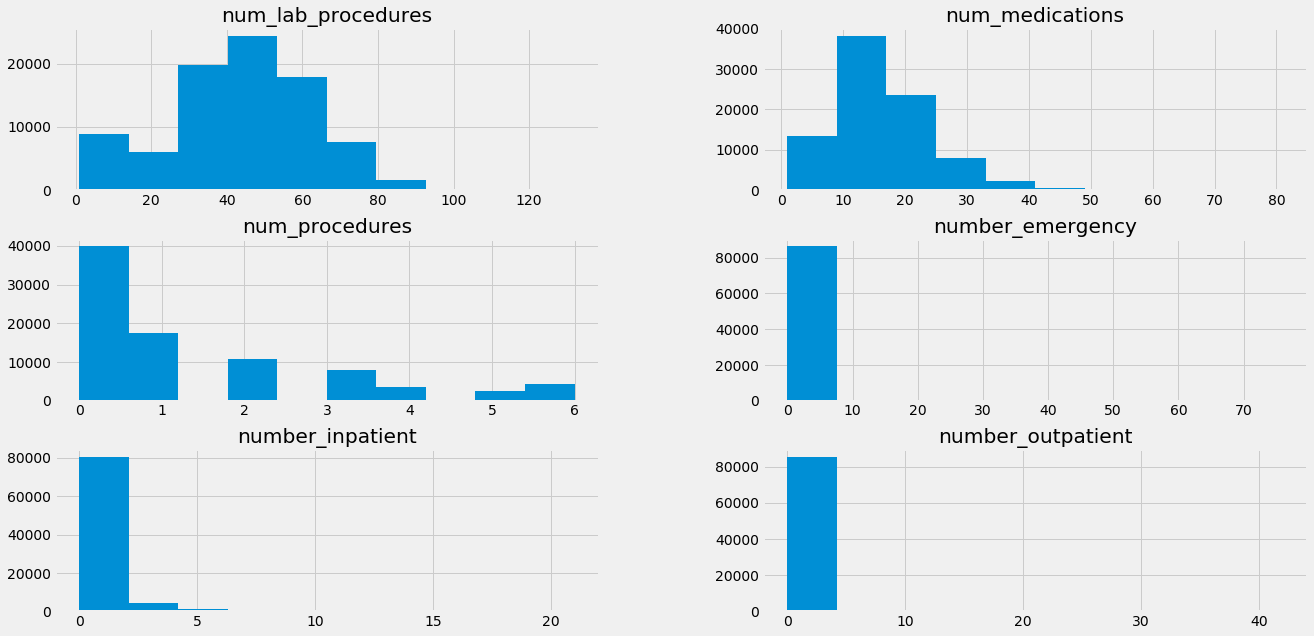

In [109]:
ax = numeric_features.hist(figsize=(20, 10))

We have some skewness in the number_inpatient, number_outpatient, and number_emergency. So we should keep that in mind when modeling

# Analysis and Modeling #

For this analysis, we will be implementing a decision tree classifier, random forest classifier, and an ada boost classifier to determine whether or not a given patient will be readmitted within 30 days, after 30 days, or not at all.

In [121]:
#import all the things!!

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

First, we split the dataframe into features columns and classification column

In [ ]:
dbd.columns

In [117]:
#create list of features

features = [
    'race', 
    'gender', 
    'admission_type_id', 
    'discharge_disposition_id',
    'admission_source_id', 
    'time_in_hospital', 
    'num_lab_procedures',
    'num_procedures',
    'num_medications', 
    'number_outpatient',
    'number_emergency', 
    'number_inpatient', 
    'number_diagnoses', 
    'metformin',
    'repaglinide', 
    'nateglinide', 
    'chlorpropamide', 
    'glimepiride',
    'acetohexamide', 
    'glipizide', 
    'glyburide', 
    'tolbutamide',
    'pioglitazone', 
    'rosiglitazone', 
    'acarbose', 
    'miglitol', 
    'troglitazone',
    'tolazamide', 
    'examide', 
    'citoglipton', 
    'insulin', 
    'change',
    'diabetesMed', 
    'age_[10-20)', 
    'age_[20-30)',
    'age_[30-40)', 
    'age_[40-50)', 
    'age_[50-60)', 
    'age_[60-70)',
    'age_[70-80)', 
    'age_[80-90)', 
    'age_[90-100)'
]

In [118]:
#split dataframe into X and y features
X = dbd.loc[:, features]
y = dbd.loc[:, 'readmitted']

In [122]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)

## Null Model ##

We will be evaluating our models against a null model that predicts the most common occurance every single time

In [130]:
y.value_counts()

0    46728
2    30116
1     9663
Name: readmitted, dtype: int64

**The null model would predict with ~51% accuracy**

## Decision Tree Classifier ##

First we're going to train and test a decision tree classifier

In [125]:
#instantiate decision tree
dtree = DecisionTreeClassifier(max_depth= None)

In [149]:
dtree.fit(Xtrain, ytrain)
ypred = dtree.predict(Xtest)
print('Decision Tree acc:', accuracy_score(ytest, ypred))

Decision Tree acc: 0.4706109009387698


It looks like the Decision Tree performed worse than the null model, so we can examine feature importances

In [131]:
pd.DataFrame({'feature': features, 'importance': dtree.feature_importances_}).sort_values(by='importance', ascending = False)

,feature,importance
6,num_lab_procedures,0.175899
8,num_medications,0.137926
5,time_in_hospital,0.096316
7,num_procedures,0.059216
3,discharge_disposition_id,0.054079
12,number_diagnoses,0.048724
11,number_inpatient,0.042574
30,insulin,0.037145
0,race,0.033069
1,gender,0.027069


It looks like we have a lot of features with negligible impact, so we will filter out those features using SelectFromModel 

In [132]:
#Instantiate and set a 5% threshold for features, so any feature with less than 5% impact is removed
sfm = SelectFromModel(dtree, threshold = 0.05)

#Fit selector on training data
sfm.fit(Xtrain, ytrain)

SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
        norm_order=1, prefit=False, threshold=0.05)

In [133]:
#transform features and remove unimportant features for training data
X_important_train = sfm.transform(Xtrain)

#transform features and remove unimportant features for testing data
X_important_test = sfm.transform(Xtest)

In [150]:
dtree_important = DecisionTreeClassifier(max_depth = None)

dtree_important.fit(X_important_train, ytrain)
ypred = dtree_important.predict(X_important_test)
print('Decision Tree Modified Acc:', accuracy_score(ytest, ypred))

Decision Tree Modified Acc: 0.46542664985287935


It looks like removing features made the model perform even worse, so let's try our luck with the ensemble classifiers

## Random Forest Classifier ##

Next, we're going to train a Random Forest Classifier to predict readmission status

In [136]:
#instantiate Random Forest Classifier
rfclass = RandomForestClassifier(n_estimators = 100)

In [151]:
#train, fit, and test
rfclass.fit(Xtrain, ytrain)
ypred = rfclass.predict(Xtest)
print('Random Forest Acc:', accuracy_score(ytest, ypred))

Random Fores Acc: 0.5757671290458176


The ensemble showed significant improvement! Let's look at feature importances next and see if we can improve it even more

In [160]:
pd.DataFrame({'feature': features, 'importance': rfclass.feature_importances_}).sort_values(by='importance', ascending = False)

,feature,importance
6,num_lab_procedures,0.151578
8,num_medications,0.129015
5,time_in_hospital,0.094432
7,num_procedures,0.060835
12,number_diagnoses,0.056764
3,discharge_disposition_id,0.056490
11,number_inpatient,0.051493
30,insulin,0.037545
0,race,0.032212
1,gender,0.029243


Similar to above, we're going to try removing some unimportant features to see the effect on performance

In [140]:
sfm = SelectFromModel(rfclass, threshold = 0.05)

sfm.fit(Xtrain, ytrain)
X_important_train = sfm.transform(Xtrain)
X_important_test = sfm.transform(Xtest)

In [152]:
rfclass_important = RandomForestClassifier(n_estimators = 100)

rfclass_important.fit(X_important_train, ytrain)
ypred = rfclass_important.predict(X_important_test)
print('Random Forest Modified Acc:', accuracy_score(ytest, ypred))

Random Forest Modified Acc: 0.5285484096959506


It looks like removing features forced the model performed worse, so let's try our luck with boosting

## Adaboost Classifier ##

In [161]:
#instantiate Ada Boost ensemble, and set learning rate to 0.1 to increase accuracy
bclass = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
bclass.fit(Xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=500, random_state=None)

In [162]:
ypred = bclass.predict(Xtest)
print('Boost acc:', accuracy_score(ytest, ypred))

Boost acc: 0.5842791088692728


In [163]:
sfm = SelectFromModel(bclass, threshold = 0.05)

sfm.fit(Xtrain, ytrain)
X_important_train = sfm.transform(Xtrain)
X_important_test = sfm.transform(Xtest)

In [164]:
boost_important = AdaBoostClassifier(n_estimators = 500, learning_rate =0.1)

boost_important.fit(X_important_train, ytrain)
ypred = boost_important.predict(X_important_test)
print('boost_important acc:', accuracy_score(ytest, ypred))

boost_important acc: 0.5806361216197282


Again, it looks like feature selection didn't help our model. We can go with our highest performing model, which is the original Adaboost Classifier, which predicted with ~59% accuracy.

# Conclusion #

In summary, we cleaned and prepared a dataset with over 110,000 rows and 55 features, and implemented 3 classifiers to estimate readmission rates in patients with diabetes. 

When measured against our null model, our best Classifier performed 8 percentage points better (15% improvement) when classifying patient readmission. 

Although this a modest increase (given the amount of work that was put into developing the model), predicting and reducing readmissions by 8% can have signficant cost savings for healthcare systems, considering that the cost of diabetic readmission in 2017 was over $300M.